# Workshop 09

#### Note that API key was deleted.

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Social Media Analytics
- Course ID: BDA600NAA.07578.2241
- Professor: Dr. Pantea Koochemeshkian

In [23]:
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

In [1]:
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
REDIRECT_URI = 'http://localhost:8080/'  # Fixed redirect URI

def create_api_connection():
    flow = InstalledAppFlow.from_client_secrets_file(
        'credentials.json', SCOPES, redirect_uri=REDIRECT_URI)
    creds = flow.run_local_server(port=8080)  # Match the redirect URI port
    service = build('gmail', 'v1', credentials=creds)
    return service

service = create_api_connection()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1048725142000-211ljdavl201rrb7scuccnirj7t7mbu7.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.readonly&state=cxNIwPeWwZdIFj0LvToiZKmXpVnOmg&access_type=offline


In [2]:
def query_inbox(service, query='newer_than:30d'):
    results = service.users().messages().list(userId='me', q=query).execute()
    messages = results.get('messages', [])

    for message in messages[:5]:  # Get first 5 messages as an example
        msg = service.users().messages().get(userId='me', id=message['id']).execute()
        print(f"Message snippet: {msg['snippet']}")

        # Get full message content and other details as needed

query_inbox(service)


Message snippet: Hi Ran Arino, Kaggle Community Competitions are our self-service platform that anyone can create and host a competition at no cost. Check out these Community Competitions to practice developing models
Message snippet: Hello Ran, Tune in to our YouTube Live session focused on Copilot.us Apps, where we&#39;ll show you how to access our independent AI applications without a ChatGPT subscription. We will explore
Message snippet: Bell Ringing Ceremony at Toronto Stock Exchange ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌
Message snippet: Enjoy a weekend away with Marriott Bonvoy Escapes. ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌
Message snippet: Plus enjoy Barcelona, explore Hong Kong or fly with flexibility with a Flight Pass Plus enjoy Barcelona, explore Hong

In [13]:
def get_messages(service, query='newer_than:30d'):
    result = service.users().messages().list(userId='me', q=query).execute()
    messages = result.get('messages', [])
    
    texts = []
    for message in messages:
        msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
        
        try:
            # Get the date of the message
            msg_date = msg['internalDate']
            date_parse = (datetime.fromtimestamp(int(msg_date) / 1000))
            msg_date = date_parse.strftime("%Y-%m-%d")

            # Get the message snippet and subject
            snippet = msg['snippet']
            subject = ""
            for header in msg['payload']['headers']:
                if header['name'] == 'Subject':
                    subject = header['value']
            
            texts.append(subject + " " + snippet)
        except Exception as e:
            print(f'Error: {e}')
            pass
    
    return texts

# Clean email content
def clean_texts(raw_texts: np.array):
    # define result
    result = []

    # set of stopwords
    stop_words = set(stopwords.words('english'))
    # set the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # function to get the wordnet pos
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        else:
            # Default to noun
            return wordnet.NOUN

    # traversing all sentences
    for sent in raw_texts:
        # (1): white space removal
        sent = sent.strip()
        # (2): URL removal
        sent = re.sub(r"http[s]?://[\w?\W?]+", '', sent)
        # (3): HTML tag removal
        sent = re.sub(r'<[^>]+>', '', sent)
        # (4): Repeated words (at least four times)
        sent = re.sub(r'(.)\1{4,}', r'\1', sent)
        # (5): split attached words (at least two characters and follow the capitalized word)
        sent = re.sub(r"([\w]{2,})([A-Z])", r"\1 \2", sent)
        # (6): Punctuation removal
        sent = re.sub(r'[^\w\s]', '', sent)
        # (7): lemmatizaiton & tokenization
        token = nltk.word_tokenize(sent)
        tagged_token = nltk.pos_tag(token)
        lemma_token = [
            lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1]))
            for w in tagged_token
            # Only focusing on noun ('NN', 'NNP')
            if w[1] in ['NN', 'NNP']
        ]
        # defined cleaned sentence
        clean_sent = ''
    
        # cleaning each sentence
        for w in lemma_token:
            # if 'w' is one of stop words, skip to the next word
            if w.lower() in stop_words:
                continue
            # add words
            clean_sent += w.lower() + ' '

        # add clean_sent to result (make sure that the last item is always blank)
        result += [clean_sent[:-1]]

    return result

# Analyze the text for frequent words
def analyze_texts(texts):
    all_text = ' '.join(texts)
    words = re.findall(r'\w+', all_text.lower())
    common_words = Counter(words).most_common(20)  # Get the 20 most common words

    return common_words

# Fetching messages and analyzing text
texts = get_messages(service)
texts_ = clean_texts(texts)
common_words = analyze_texts(texts_)
print(common_words)

[('portfolio', 48), ('ran', 27), ('top', 18), ('digest', 17), ('arino', 16), ('premarket', 16), ('logo', 16), ('ai', 15), ('see', 15), ('medium', 14), ('march', 14), ('news', 14), ('et', 14), ('performance', 13), ('summary', 12), ('amp', 12), ('analysis', 12), ('sa', 12), ('mar', 12), ('yesterday39s', 12)]


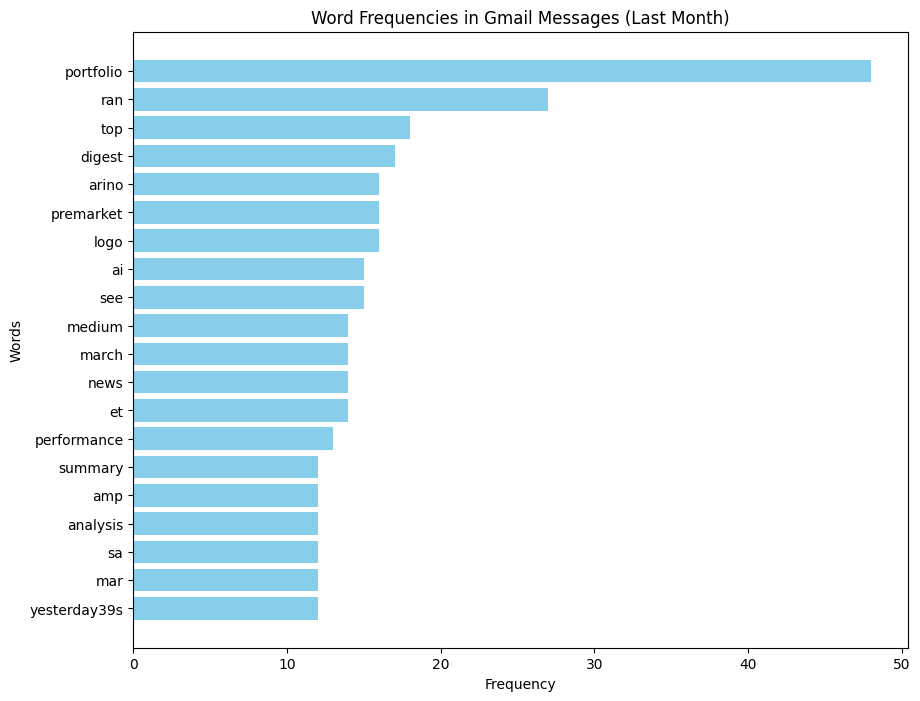

In [22]:

# Separate the words and their frequencies
words, frequencies = zip(*common_words)

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Word Frequencies in Gmail Messages (Last Month)')
plt.gca().invert_yaxis()  # Invert y axis to have the highest frequency at the top
plt.show()